[View in Colaboratory](https://colab.research.google.com/github/adrshm91/DrivFace/blob/master/DrivFace_Resnet.ipynb)

In [0]:
import wget
import os
from zipfile import PyZipFile
import shutil
import glob
import pandas as pd
temp_dir = 'data/temp'
orig_dir = 'data/images'
train_dir = 'data/train'
val_dir = 'data/val'
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00378/DrivFace.zip'
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
SHAPE = (HEIGHT, WIDTH, CHANNELS)

In [0]:
def load_dataset():
  if not os.path.exists(orig_dir):
    
    # download the dataset
    
    os.makedirs(temp_dir)
    os.makedirs(orig_dir)
    print("Downloading dataset to "+ temp_dir)
    file = wget.download(url, out=temp_dir)
    print("\nUnzipping the files..")
    pzf = PyZipFile(file)
    pzf.extractall(temp_dir)
    pzf = PyZipFile(temp_dir+'/DrivFace/DrivImages.zip')
    pzf.extractall(temp_dir)
    print("Moving files to "+orig_dir)
    for file in os.listdir(temp_dir+'/DrivImages'):
      shutil.move(temp_dir+'/DrivImages/'+file,orig_dir+'/'+file)
    shutil.move(temp_dir+'/DrivFace/drivPoints.txt',orig_dir+'/drivPoints.txt')
    print("Deleting temporary directory "+ temp_dir)
    shutil.rmtree(temp_dir)

In [0]:
def split_dataset(orig_dir, train_dir, val_dir, split_ratio):
  
  if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    print("Creating train directories for each class")
    train_ff_dir = os.path.join(train_dir, 'ff')
    os.makedirs(train_ff_dir)
    train_ll_dir = os.path.join(train_dir, 'll')
    os.makedirs(train_ll_dir)
    train_lr_dir = os.path.join(train_dir, 'lr')
    os.makedirs(train_lr_dir)

    print("Creating val directories for each class")
    val_ff_dir = os.path.join(val_dir, 'ff')
    os.makedirs(val_ff_dir)
    val_ll_dir = os.path.join(val_dir, 'll')
    os.makedirs(val_ll_dir)
    val_lr_dir = os.path.join(val_dir, 'lr')
    os.makedirs(val_lr_dir)

    files = pd.read_csv(orig_dir+'/drivPoints.txt')['fileName'].tolist()
    files_ff = [file for file in files if 'f' in file]
    files_ll = [file for file in files if 'll' in file]
    files_lr = [file for file in files if 'lr' in file]
    i = 0
    for fname in files_ff:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ff_dir, fname + '.jpg')
      dst_val = os.path.join(val_ff_dir, fname + '.jpg')
      i += 1
      if i < len(files_ff)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_ll:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_ll_dir, fname + '.jpg')
      dst_val = os.path.join(val_ll_dir, fname + '.jpg')
      i += 1
      if i < len(files_ll)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)
    i = 0
    for fname in files_lr:
      src = os.path.join(orig_dir, fname + '.jpg')                        
      dst_train = os.path.join(train_lr_dir, fname + '.jpg') 
      dst_val = os.path.join(val_lr_dir, fname + '.jpg')
      i += 1
      if i < len(files_lr)*split_ratio:
        shutil.move(src, dst_train)
      else:
        shutil.move(src, dst_val)

In [5]:
load_dataset()


Unzipping the files..
Moving files to data/images
Deleting temporary directory data/temp


In [6]:
split_dataset(orig_dir, train_dir, val_dir, split_ratio = 0.8)

Creating train directories for each class
Creating val directories for each class


In [7]:
from keras import layers
from keras import models

Using TensorFlow backend.


In [8]:
from keras.applications import ResNet50

conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(SHAPE))

94658560/94653016 [==============================] - 3s 0us/step


In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
conv_base.trainable = False
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 24,113,027
Trainable params: 525,315
Non-trainable params: 23,587,712
_________________________________________________________________


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)                

train_generator = train_datagen.flow_from_directory(
        train_dir,                                               
        target_size=(HEIGHT, WIDTH),                                  
        batch_size=20,
        class_mode='categorical')                                     

validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(HEIGHT, WIDTH),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 483 images belonging to 3 classes.
Found 123 images belonging to 3 classes.


In [12]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 56s 563ms/step - loss: 0.3887 - acc: 0.9007 - val_loss: 0.6540 - val_acc: 0.8956
Epoch 2/30
100/100 [==============================] - 48s 481ms/step - loss: 0.3337 - acc: 0.9032 - val_loss: 0.5933 - val_acc: 0.8933
Epoch 3/30
100/100 [==============================] - 48s 481ms/step - loss: 0.3002 - acc: 0.9027 - val_loss: 0.5751 - val_acc: 0.8933
Epoch 4/30
100/100 [==============================] - 48s 481ms/step - loss: 0.2807 - acc: 0.9047 - val_loss: 0.5614 - val_acc: 0.8967
Epoch 5/30
100/100 [==============================] - 48s 484ms/step - loss: 0.2715 - acc: 0.9054 - val_loss: 0.5540 - val_acc: 0.8956
Epoch 6/30
100/100 [==============================] - 48s 480ms/step - loss: 0.2525 - acc: 0.9155 - val_loss: 0.5549 - val_acc: 0.8933
Epoch 7/30
100/100 [==============================] - 48s 481ms/step - loss: 0.2273 - acc: 0.9190 - val_loss: 0.5358 - val_acc: 0.8956
Epoch 8/30
100/100 [==============================] - 4

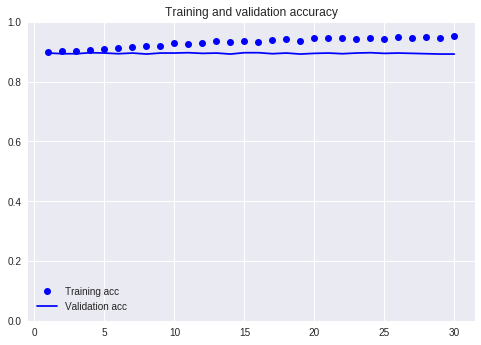

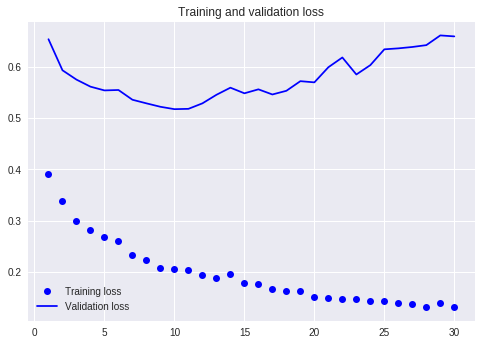

In [13]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.ylim(0,1)

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
model.save('DrivFace-ResNet.h5')

In [15]:
!ls

data  DrivFace-ResNet.h5  sample_data
